# How To : Apply Coning Compensation

Demonstrate coning compensation on integrated angular rate measurements {cite}`christian2025rungekuttaapproximationsdirectconing`.

```{contents} Table of Contents
:depth: 2
```

In [9]:
import sys, os

sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np
from scipy.interpolate import BPoly

import matplotlib.pyplot as plt

# %matplotlib ipympl

from functools import partial

# Custom package for computing basis functions and derivatives
from hitman.ode import butcher_tableaux, ButcherTableau
from hitman.ode import rkmk_fixed_discrete
from hitman.rotation import LieExponential as SO
from hitman.plot import plot_hermite_spline
from hitman.gyro import functional_factory

## Measurement and Solution Functions

Consider the relationships

$$ \Delta R(t) = \exp\big(-\phi(t-\tau)\big)\exp\big(\phi(t)\big) $$

$$ \dot{\phi} = \left(J_\phi^r\right)^{-1} \omega^r $$

$$ \Delta \theta = \int_{t-\tau}^t \omega^r(s) ds $$

Our goal is to score methods for approximating change in attitude, $\Delta \widetilde{R} $, from measurements $\Delta \theta$. As a test case we define an attitude trajectory using a single polynomial function. We may choose to define either  $\omega$ or $\phi$. The {py:func}`functional_factory` then generates measurement functional $ \Delta \theta $ and truth solution $ \Delta R $ from a single polynomial expression: either $\omega$ or $\phi$.

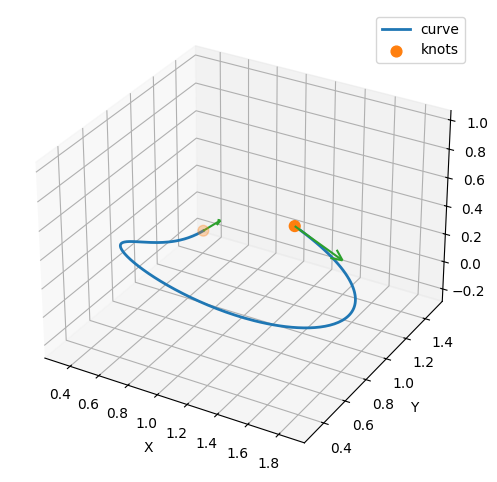

In [10]:
# Benign trajectory
A = np.array(
    [
        [1, 0, -1],
        [4 / 3, 0, -4 / 3],
        [11 / 6, 1 / 3, -11 / 3],
        [5 / 2, 4 / 3, -4 - np.pi],
    ]
)
is_omega = True

# Generate random control points
np.random.seed(0)
A = np.random.randn(6, 3)
is_omega = False

# Form polynomial and required model functions
f = BPoly(A[:, np.newaxis, :], [0.0, 1.0])
_, _ = plot_hermite_spline(f, x=[0, 1])

eval_delta_theta, eval_delta_R, eval_omega = functional_factory(f, is_omega)

## Propagation Equations

Differential equations are typically expressed in terms of instantaneous rates. However, many gyroscopes provide integrate rate measurements. Since we have both instantaneous rates, `eval_omega`, and integrated rates, `eval_delta_theta`, we can contrast performance of state propagation algorithms from either measurement category.

### Instantaneous Rate Propagation
Instantaneous rates can be propagated using the RKMK method {cite}`iserles2000lie`. Different solver orders are utilized depending on which Butcher tableau specified. Note, the tableau determines the number of measurements required as well.


In [11]:
def rkmk(homega: np.ndarray, tableau: ButcherTableau) -> np.ndarray:
    """Solve attitude update from instantaneous rates

    Args:
       homega: instantaneous rates, scaled by step size
       tableau: ButcherTableau specifying the RK method

    Returns:
       Rotation matrix
    """

    # input checking
    assert isinstance(tableau, ButcherTableau), "Input must be tableau"
    N = np.unique(tableau.c).size
    # size of homega must match tableau
    assert (
        homega.shape[0] == N
    ), "For provided tableau, expecting %d samples of omega, received %d" % (
        N,
        homega.shape[0],
    )

    # apply rkmk algorithm and map to SO(3)
    delta_phi = rkmk_fixed_discrete(homega, np.zeros_like(homega[0]), tableau)
    return SO.exp(delta_phi)

### Integrated Rate Propagation

Propagating integrated rate measurements requires models and approximations. One approach is to model the instantaneous rates as a curve fit to the integrated measurements. Generating samples of instantaneous rate enables use of generalized RK-style solvers.

In [12]:
def resample_delta_theta(
    delta_theta: np.ndarray, tau: float, sample_points=np.array([0, 0.5, 1])
):
    """Resample delta-theta measurements as polynomial fit of instantaneous rate"""
    if delta_theta.shape[0] == 1:
        homega_approx = delta_theta
    elif delta_theta.shape[0] == 2:
        A = np.array([[-0.5 * (tau**2), tau], [0.5 * (tau**2), tau]])
    elif delta_theta.shape[0] == 3:
        A = np.array(
            [
                [(tau**3) / 3, -0.5 * (tau**2), tau],
                [(tau**3) / 3, 0.5 * (tau**2), tau],
                [7 * (tau**3) / 3, 1.5 * (tau**2), tau],
            ]
        )
    else:
        raise NotImplementedError(
            "Requires one, two, or three delta-theta measurements"
        )

    if delta_theta.shape[0] > 1:
        p = np.linalg.solve(A, delta_theta)
        t_local = tau * sample_points
        homega_approx = tau * np.vander(t_local, p.shape[0]) @ p

    return homega_approx


Generalized solvers are computationally expensive. Instead of resampling instantaneous rates and applying generalized solvers, it is possible to approximate the solver solutions from integrated rate measurements directly {cite}`christian2025rungekuttaapproximationsdirectconing`. Here we demonstrate approximations for 2 and 3 integrated rate measurements.

In [13]:
def SingleSpeed2(delta_theta):
    """Approximate delta-R from two delta-theta measurements"""
    assert delta_theta.shape[0] == 2, "Requires two delta-theta measurements"
    delta_phi = np.zeros_like(delta_theta[0])
    k = 1
    delta_phi += delta_theta[k] + np.cross(delta_theta[k - 1], delta_theta[k]) / 12
    return SO.exp(delta_phi)


def SingleSpeed3(delta_theta):
    """Approximate delta-R from three delta-theta measurements"""
    assert delta_theta.shape[0] == 3, "Requires three delta-theta measurements"
    delta_phi = np.zeros_like(delta_theta[0])
    k = 1
    delta_phi += (
        delta_theta[k]
        + (
            np.cross(delta_theta[k + 1], delta_theta[k - 1])
            + 13 * np.cross(delta_theta[k - 1] - delta_theta[k + 1], delta_theta[k])
        )
        / 12
        / 24
    )
    return SO.exp(delta_phi)

## Benchmark Algorithms
Define a dictionary of algorithms to contrast. For each algorithm, we indicate 

 * ``func`` : solver functional to operate on the sampled rates
 * ``n_samples`` : number of samples required by the solver
 * ``rate`` : whether the rate samples are `instantaneous`, $\omega$; `integrated` ,$\Delta \theta$; or `resampled` instantaneous rates derived by curve fitting to integrated rates.

In [14]:
algorithm_dict = {
    "FwdElr_omega": {
        "func": partial(rkmk, tableau=butcher_tableaux["FwdElr"]),
        "n_samples": 1,
        "rate": "instantaneous",
    },
    "ExMid_omega": {
        "func": partial(rkmk, tableau=butcher_tableaux["ExpMid"]),
        "n_samples": 2,
        "rate": "instantaneous",
    },
    "RK3_omega": {
        "func": partial(rkmk, tableau=butcher_tableaux["RK3"]),
        "n_samples": 3,
        "rate": "instantaneous",
    },
    "RK4_omega": {
        "func": partial(rkmk, tableau=butcher_tableaux["RK4"]),
        "n_samples": 3,
        "rate": "instantaneous",
    },
    "FwdElr_delta": {
        "func": partial(rkmk, tableau=butcher_tableaux["FwdElr"]),
        "n_samples": 1,
        "rate": "resampled",
    },
    "ExMid_delta": {
        "func": partial(rkmk, tableau=butcher_tableaux["ExpMid"]),
        "n_samples": 2,
        "rate": "resampled",
    },
    "RK3_delta": {
        "func": partial(rkmk, tableau=butcher_tableaux["RK3"]),
        "n_samples": 3,
        "rate": "resampled",
    },
    "RK4_delta": {
        "func": partial(rkmk, tableau=butcher_tableaux["RK4"]),
        "n_samples": 3,
        "rate": "resampled",
    },
    "SingleSpeed2": {
        "func": SingleSpeed2,
        "n_samples": 2,
        "rate": "integrated",
    },
    "SingleSpeed3": {
        "func": SingleSpeed3,
        "n_samples": 3,
        "rate": "integrated",
    },
}

## Sample Trajectory
Define trajectory as a polynomial curve in $\mathbb{R}\rightarrow \mathbb{R}^3$. The curve may represent $\omega$ or $\phi$. 

Score algorithms and save results in :class:`pandas.DataFrame`.

In [15]:
import pandas as pd
import itertools

# Increasing step sizes
tau_all = np.logspace(-6, -1, num=20)

# Random sample points for trajectory
t_all = np.random.uniform(0.1, 0.9, 20)

# Generate all combinations of tau and t
combinations = list(itertools.product(tau_all, t_all))

# Create a DataFrame from the combinations
df = pd.DataFrame(combinations, columns=["tau", "t"])

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    tau = row["tau"]
    t = row["t"]

    # Generate instantaneous rate measurements
    omega = np.array([eval_omega(t) for t in t + tau * np.arange(-1, 0.5, 0.5)])

    # Generate sequential integrated rate measurements
    delta_theta = np.vstack([eval_delta_theta(t + k * tau, tau) for k in range(-1, 2)])

    # Define the truth eval_delta_R
    Rstar = eval_delta_R(t, tau)
    assert eval_omega([1, 1.5]).shape == (2, 3), "Wrong omega dims!"

    # Benchmark each algorithm in the dictionary
    for key, algorithm_data in algorithm_dict.items():
        func = algorithm_data["func"]
        n_samples = algorithm_data["n_samples"]
        rate = algorithm_data["rate"]

        if rate == "instantaneous":
            # instantaneous rate measurements
            #   * Note * RKMK requires measurements scaled by timestep!
            dat = tau * np.atleast_2d(omega[0:n_samples, :])
        elif rate == "integrated" or rate == "resampled":
            dat = np.atleast_2d(delta_theta[0:n_samples, :])
            if rate == "resampled":
                # approximate h-omega by resampling
                dat = resample_delta_theta(dat, tau)[0:n_samples, :]
        else:
            raise ValueError(f"Invalid rate: {rate}")

        # propagate
        Rhat = func(dat)
        # score
        err = np.linalg.norm(Rhat - Rstar)
        # retain result
        df.at[index, key] = err

### Plot Results

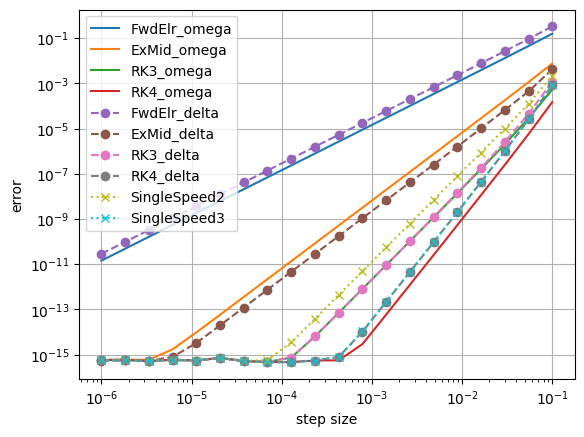

In [16]:
df_mean = df.groupby("tau").mean().reset_index()

# get column names of df_mean (excluding 'tau')
column_names = df_mean.columns[2:].tolist()

# plot loglog of df_mean using columns 1:-
for i, column in enumerate(column_names):
    if i < len(column_names) - 6:  # solid lines for first column
        linestyle = "-"
        marker = None
    elif i < len(column_names) - 2:  # solid lines for first column
        linestyle = "--"
        marker = "o"
    else:
        linestyle = ":"
        marker = "x"

    plt.loglog(
        df_mean.iloc[:, 0],
        df_mean[column],
        linestyle=linestyle,
        label=column,
        marker=marker,
    )
# plt.ylim([1e-16, 1])
plt.legend()
plt.grid(True)
plt.xlabel("step size")
plt.ylabel("error")
plt.show()